<a href="https://colab.research.google.com/github/JeehwanLim/202103-adv_ml/blob/main/midterm_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

임지환, 2020511027

https://colab.research.google.com/drive/1Vmm3NfNZLY2R5THsQ1nUihvWP-sZlKRw#scrollTo=_6Oz-WAfrdlT

# **Bayesian regression 과제**
## 1. train data 가져오기

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 5.9MB/s 
     |████████████████████████████████| 4.7MB 51.4MB/s 
     |████████████████████████████████| 317kB 25.9MB/s 
     |████████████████████████████████| 911kB 5.9MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 4.1MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=f7d808e224bcf5126a5ad14feddf1ef4d8796c51b14ce64adeabcde362c4bfe2
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import pymc3 as pm
import arviz
import pickle

%matplotlib inline

In [3]:
!git clone https://github.com/JeehwanLim/202103-adv_ml.git

Cloning into '202103-adv_ml'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [4]:
df = pd.read_csv('202103-adv_ml/train_data.csv', sep=',')
df.shape

(1607, 143)

## 2. 탐색적 자료 분석

In [5]:
# pd.options.display.min_rows = 200

In [6]:
df.head()

ADAS11  ADAS13  MMSE  ST102CV  ...  ST95TA  ST97TA  ST98TA  ST99TA
0    9.00   14.00    27     3295  ...   2.519   1.606   2.363   2.864
1    5.00    7.00    26     3644  ...   2.269   1.868   2.142   2.679
2   16.33   29.33    25     3096  ...   2.534   1.996   2.163   2.643
3    6.00    9.00    29     3857  ...   2.315   1.954   2.326   2.989
4    5.00    8.00    28     3411  ...   2.497   2.052   2.498   2.829

[5 rows x 143 columns]

In [7]:
df.describe()

ADAS11       ADAS13  ...       ST98TA       ST99TA
count  1607.000000  1607.000000  ...  1607.000000  1607.000000
mean     10.687623    16.838836  ...     2.264312     2.705311
std       6.564644     9.519048  ...     0.206316     0.227434
min       0.000000     0.000000  ...     1.547000     1.756000
25%       6.000000     9.330000  ...     2.133500     2.596500
50%       9.000000    15.000000  ...     2.268000     2.733000
75%      14.000000    23.000000  ...     2.392000     2.857500
max      42.670000    54.670000  ...     3.174000     3.280000

[8 rows x 143 columns]

In [8]:
null_obj = df.isnull().sum()
for key,value in null_obj.iteritems():
    if value > 0:
        print(key,",",value)

ST123CV , 847
ST24CV , 1
ST44CV , 1
ST64CV , 847
ST123TA , 847
ST24TA , 1
ST44TA , 1
ST64TA , 847


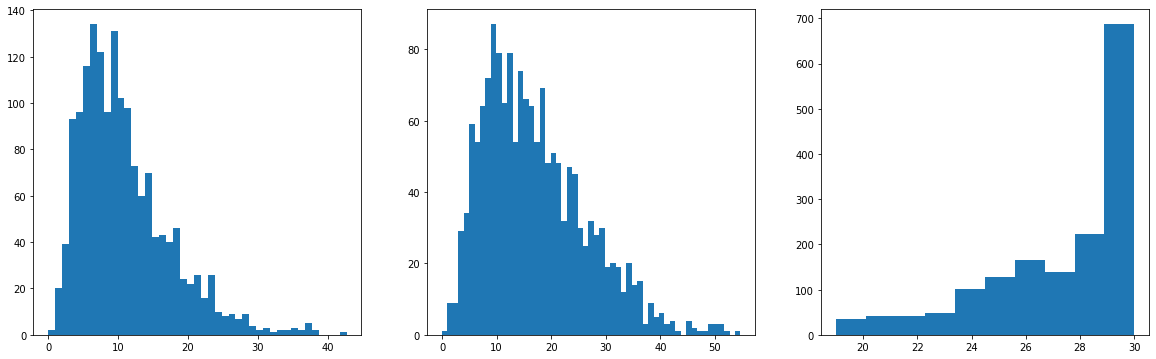

In [9]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.hist(df['ADAS11'], bins = 43)

plt.subplot(1,3,2)
plt.hist(df['ADAS13'], bins = 55)
plt.subplot(1,3,3)
plt.hist(df['MMSE'], bins = 10)

plt.show()

In [10]:
df[['ADAS11','ADAS13','MMSE']]

ADAS11  ADAS13  MMSE
0       9.00   14.00    27
1       5.00    7.00    26
2      16.33   29.33    25
3       6.00    9.00    29
4       5.00    8.00    28
...      ...     ...   ...
1602   16.00   27.00    28
1603   23.00   36.00    24
1604   28.00   40.00    23
1605   18.33   29.33    23
1606    8.00   15.00    29

[1607 rows x 3 columns]

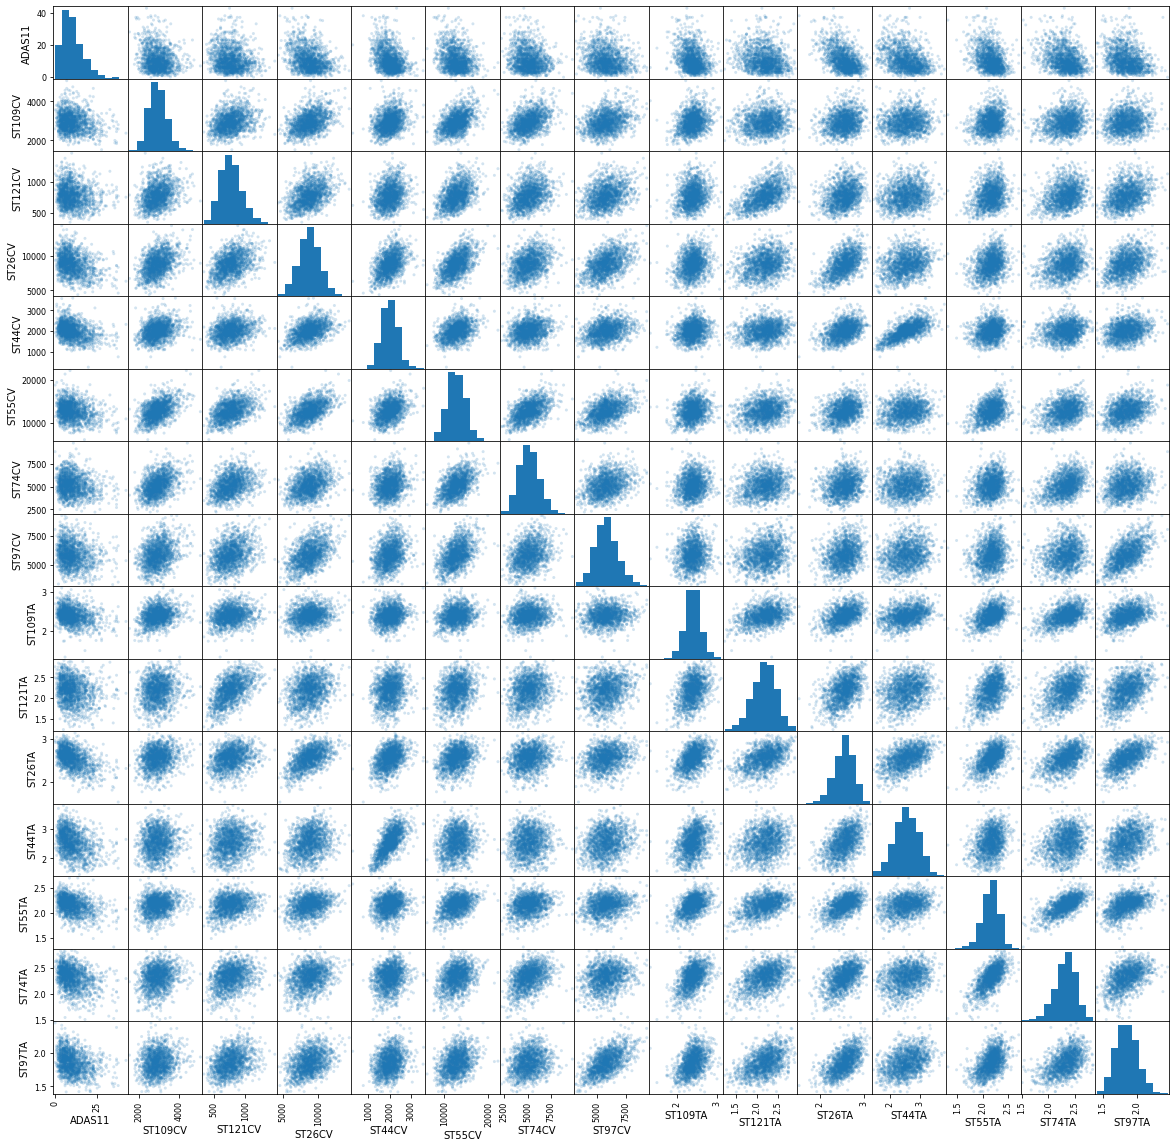

In [11]:
cor_df = df.iloc[:,[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]]
pd.plotting.scatter_matrix(cor_df,alpha=0.2,figsize=(20,20))
plt.show()

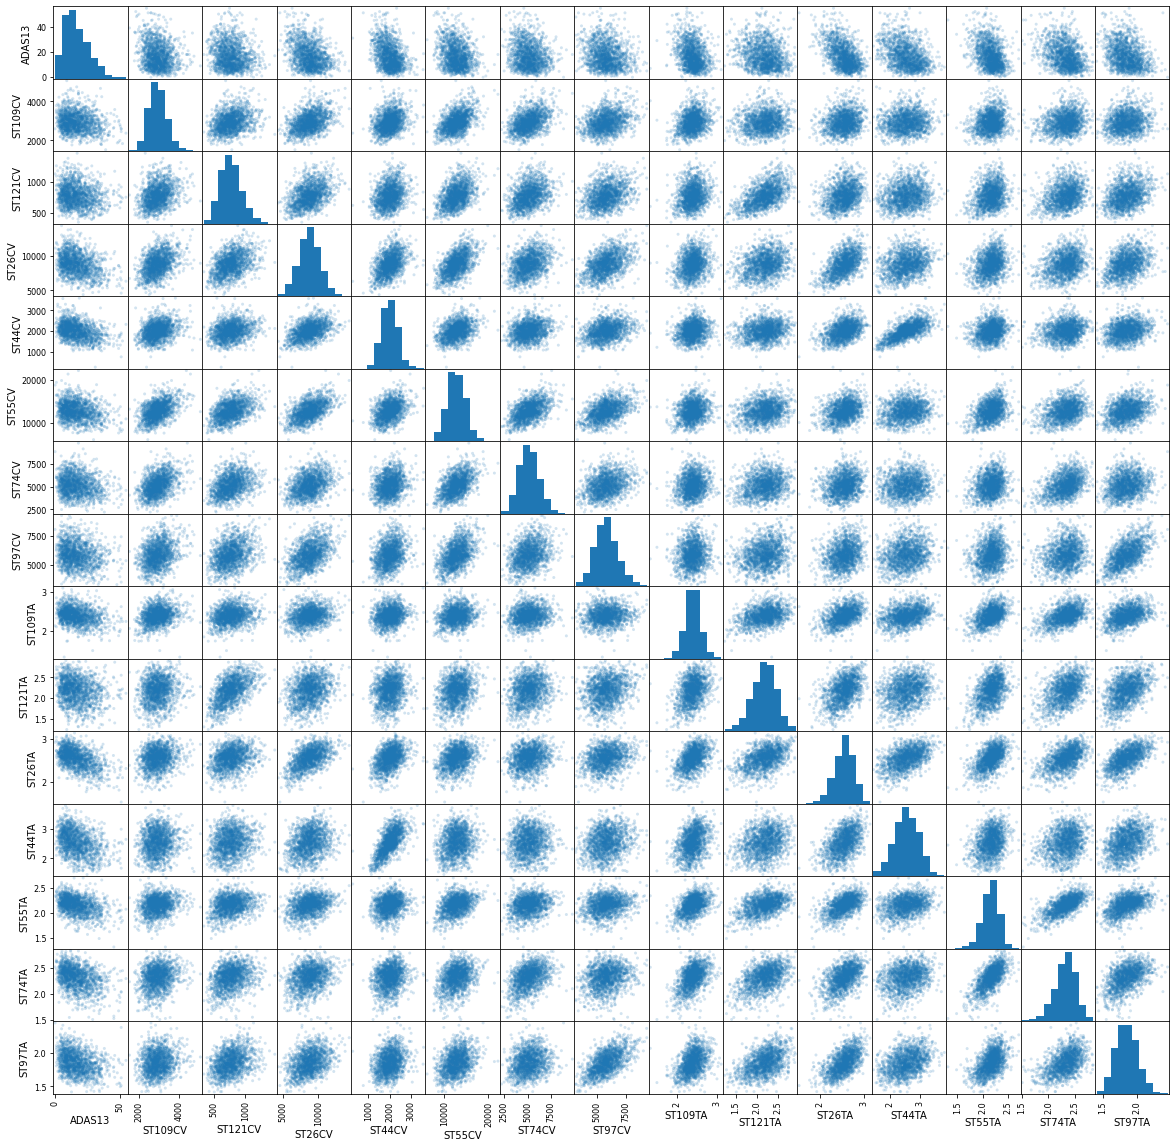

In [12]:
cor_df = df.iloc[:,[1,10,20,30,40,50,60,70,80,90,100,110,120,130,140]]
pd.plotting.scatter_matrix(cor_df,alpha=0.2,figsize=(20,20))
plt.show()

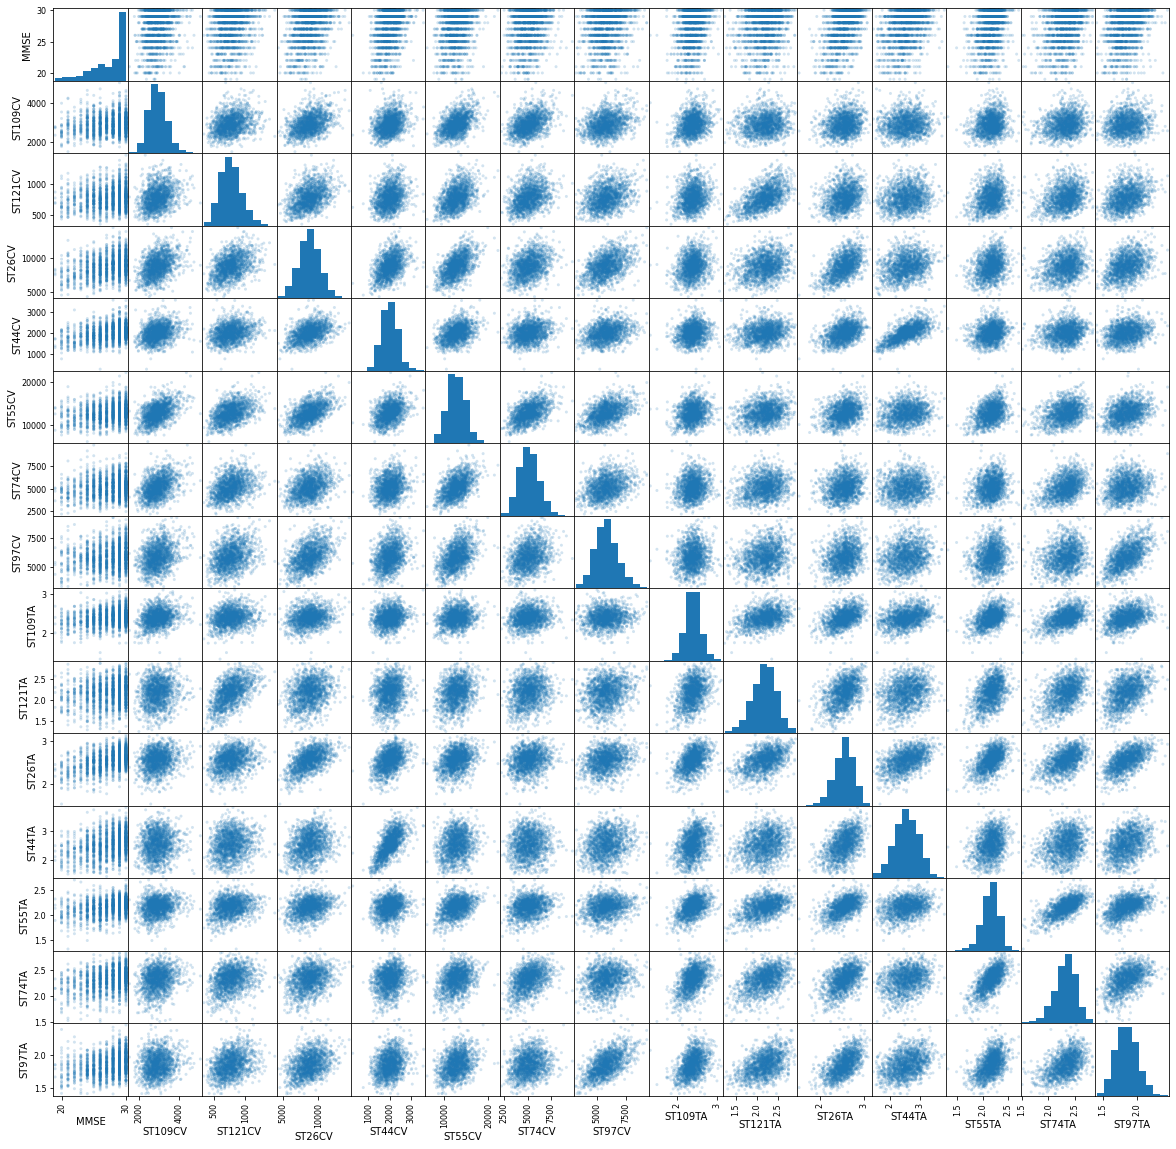

In [13]:
cor_df = df.iloc[:,[2,10,20,30,40,50,60,70,80,90,100,110,120,130,140]]
pd.plotting.scatter_matrix(cor_df,alpha=0.2,figsize=(20,20))
plt.show()

## 3. Baseline 모델로 linear regression (MLE)모델 생성

In [14]:
# 결측치 처리
# 약 4개 칼럼 제거(4개 칼럼은 50%의 데이터가 없다)
# 4개 칼럼에 대해 결측치를 가지고 있는 로우도 제거 (1개밖에 없다)

base_df = df.drop(['ST123CV','ST64CV','ST123TA','ST64TA'], axis=1)
base_df.dropna(axis=0, how='any', inplace=True)
base_df.shape

(1606, 139)

In [15]:
y=base_df.iloc[:,:3]
x=base_df.iloc[:,3:]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=123)

In [17]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1204, 136)
y_train shape: (1204, 3)
X_test shape: (402, 136)
y_test shape: (402, 3)


In [18]:
model = LinearRegression(fit_intercept=True)

In [19]:
result = model.fit(X_train, y_train)

In [20]:
model.coef_

array([[ 9.43749053e-06,  2.06150271e-04,  1.56795181e-04,
        -9.85253681e-05, -1.68654485e-05, -6.59417951e-04,
         2.65219498e-04, -1.12190552e-04,  3.32937080e-04,
         3.30478261e-04, -4.91921480e-04, -1.52789199e-04,
        -3.90734511e-05, -7.40681305e-05,  1.20099035e-04,
         1.76153215e-04,  5.00208935e-04, -5.74630216e-04,
         1.52328276e-04,  6.80939134e-05, -5.42166810e-05,
        -2.54993536e-04, -2.77259939e-04,  7.53123835e-04,
        -1.04960677e-03,  2.69959986e-04,  3.84712498e-04,
        -3.39156501e-04, -1.52720982e-04,  1.42241590e-03,
        -4.38392352e-04,  4.70820589e-04, -1.33461732e-04,
         4.01345051e-04, -3.86275484e-04,  7.48166645e-04,
         4.70171593e-04,  2.26922085e-04, -7.48222400e-04,
         8.95094561e-05, -1.17168685e-04, -3.53756882e-04,
        -8.08610099e-04,  4.19983382e-04, -4.99770055e-04,
         1.20320335e-03, -2.80584784e-04,  1.03021333e-04,
         1.09719265e-04,  4.18330129e-05, -1.46272079e-0

In [21]:
model.intercept_

array([48.39368295, 71.83261407, 14.077068  ])

In [22]:
# R square
model.score(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.531845165962819

In [23]:
prediction = model.predict(X_test)
prediction

array([[21.58398107, 32.99282028, 23.13586436],
       [21.63755218, 32.82210804, 23.51873623],
       [11.28608419, 17.44129918, 27.0243455 ],
       ...,
       [ 6.21278894, 11.09469   , 27.94424241],
       [10.95882463, 18.05268409, 26.98123571],
       [ 6.47952495, 10.26921999, 28.7734394 ]])

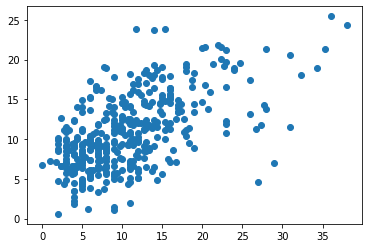

In [24]:
plt.scatter(y_test['ADAS11'], prediction[:,0])


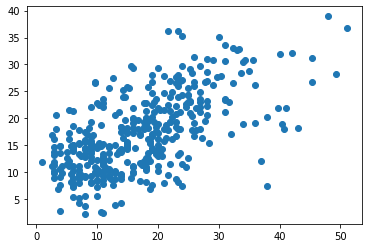

In [25]:
plt.scatter(y_test['ADAS13'], prediction[:,1])

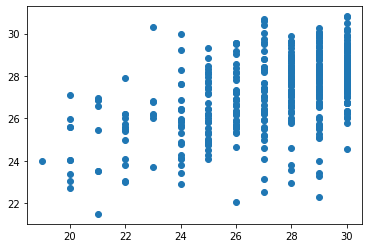

In [26]:
plt.scatter(y_test['MMSE'], prediction[:,2])

In [27]:
RMSE1 = mean_squared_error(y_test['ADAS11'], prediction[:,0])**0.5
RMSE2 = mean_squared_error(y_test['ADAS13'], prediction[:,1])**0.5
RMSE3 = mean_squared_error(y_test['MMSE'], prediction[:,2])**0.5

print('RMSE of ADAS11: {:.2f}'.format(RMSE1))
print('RMSE of ADAS13: {:.2f}'.format(RMSE2))
print('RMSE of MMSE: {:.2f}'.format(RMSE3))


RMSE of ADAS11: 5.34
RMSE of ADAS13: 7.48
RMSE of MMSE: 2.32


## 4. 데이터 전처리



In [28]:
def pre_data(df):
    # scaling
    ret_df = pd.DataFrame(scaler.transform(df),columns = df.columns)

    # null 값이 많은 칼럼 제거 
    ret_df.drop(['ST123CV','ST64CV','ST123TA','ST64TA'], axis=1, inplace=True)

    return ret_df

In [29]:
# 모델 만들 때에만 실행 
y=df.iloc[:,:3]
x=df.iloc[:,3:]

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=123)

scaler = RobustScaler()
scaler.fit(x)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [30]:
X_train = pre_data(X_train)
X_test = pre_data(X_test)

In [31]:
X_train

ST102CV   ST103CV   ST104CV  ...    ST97TA    ST98TA    ST99TA
0     1.121920  0.912707  1.230588  ... -0.585253 -0.499033  0.272031
1     0.941634 -0.554696  0.415294  ...  0.723502  0.688588  0.118774
2    -0.434501 -0.132597  0.604706  ... -0.175115  1.473888  0.318008
3    -0.476005 -0.853039 -0.475294  ... -0.672811 -1.528046 -1.429119
4     0.321660  0.733702  1.005882  ...  1.589862 -0.777563  1.555556
...        ...       ...       ...  ...       ...       ...       ...
1200  2.014267  1.255249  0.100000  ...  1.082949 -0.738878  1.130268
1201 -0.412451 -1.025414  0.137647  ... -0.235023  0.692456  0.049808
1202 -0.639429 -0.773481 -1.068235  ... -0.258065 -0.475822 -0.367816
1203  0.232166  0.797790  0.168235  ... -0.239631  0.537718  1.134100
1204  0.374838 -0.479558 -0.117647  ... -1.073733 -1.083172 -0.973180

[1205 rows x 136 columns]

## 5. 모델링

In [32]:
# 모델 웨이트 구하기, 평균을 취함
def get_weights(tr):
    weights = []
    for i in range(len(tr.varnames)):
        varnm = tr.varnames[i]
        mean = np.mean(tr[varnm])

        weights.append(mean)
    weights = np.array(weights)

    return weights

# 예측 
def predict(x_data, weights, idx):
    iv = [1]
    iv.extend(x_data.loc[idx])
    iv = np.array(iv)
    ret_val = np.dot(iv, weights[0:-2].T)

    return ret_val

# 평가
def print_RMSE(txt, y_test, pred):
    RMSE = mean_squared_error(y_test, pred)**0.5
    print('RMSE of {:10}: {:.2f}'.format(txt, RMSE))

    # 사용 예시
    # print_RMSE('ADAS11',y_test['ADAS11'],prediction)

In [33]:
def modeling(X_data, y_data):
    train_DF = X_data.copy()
    train_DF['y'] = y_data

    with pm.Model() as linear_model:
    
        # prior에 대한 사전지식이 없으므로 가급적 넓게 퍼진 정규분포로 설정 
        priors=dict()
        
        for variable in X_data.columns:
            priors[variable]=pm.Normal.dist(mu=0., sigma=10000.)

        family = pm.glm.families.Normal()
        # family = pm.glm.families.StudentT()

        # Build the model using the formula and specify the data likelihood 
        pm.GLM.from_formula(bas_func, train_DF, family = family, priors=priors)
        # pm.GLM.from_formula(bas_func, train_DF, family = family)
        # pm.GLM.from_formula(bas_func, train_DF, priors=priors)
        
        trace = pm.sample(draws=1500, tune=500, random_seed=100)
        return trace


In [34]:
# basis 함수 
bas_func = [' %s + ' % ft for ft in X_test.columns]
bas_func.insert(0, 'y ~ ')
bas_func = ' '.join(''.join(bas_func).split(' ')[:-2])
bas_func

'y ~  ST102CV +  ST103CV +  ST104CV +  ST105CV +  ST106CV +  ST107CV +  ST108CV +  ST109CV +  ST110CV +  ST111CV +  ST113CV +  ST114CV +  ST115CV +  ST116CV +  ST117CV +  ST118CV +  ST119CV +  ST121CV +  ST129CV +  ST130CV +  ST13CV +  ST14CV +  ST15CV +  ST23CV +  ST24CV +  ST25CV +  ST26CV +  ST31CV +  ST32CV +  ST34CV +  ST35CV +  ST36CV +  ST38CV +  ST39CV +  ST40CV +  ST43CV +  ST44CV +  ST45CV +  ST46CV +  ST47CV +  ST48CV +  ST49CV +  ST50CV +  ST51CV +  ST52CV +  ST54CV +  ST55CV +  ST56CV +  ST57CV +  ST58CV +  ST59CV +  ST60CV +  ST62CV +  ST72CV +  ST73CV +  ST74CV +  ST82CV +  ST83CV +  ST84CV +  ST85CV +  ST90CV +  ST91CV +  ST93CV +  ST94CV +  ST95CV +  ST97CV +  ST98CV +  ST99CV +  ST102TA +  ST103TA +  ST104TA +  ST105TA +  ST106TA +  ST107TA +  ST108TA +  ST109TA +  ST110TA +  ST111TA +  ST113TA +  ST114TA +  ST115TA +  ST116TA +  ST117TA +  ST118TA +  ST119TA +  ST121TA +  ST129TA +  ST130TA +  ST13TA +  ST14TA +  ST15TA +  ST23TA +  ST24TA +  ST25TA +  ST26TA +  ST31

In [35]:
trace = modeling(X_train, y_train['ADAS11'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [sd, ST99TA, ST98TA, ST97TA, ST95TA, ST94TA, ST93TA, ST91TA, ST90TA, ST85TA, ST84TA, ST83TA, ST82TA, ST74TA, ST73TA, ST72TA, ST62TA, ST60TA, ST59TA, ST58TA, ST57TA, ST56TA, ST55TA, ST54TA, ST52TA, ST51TA, ST50TA, ST49TA, ST48TA, ST47TA, ST46TA, ST45TA, ST44TA, ST43TA, ST40TA, ST39TA, ST38TA, ST36TA, ST35TA, ST34TA, ST32TA, ST31TA, ST26TA, ST25TA, ST24TA, ST23TA, ST15TA, ST14TA, ST13TA, ST130TA, ST129TA, ST121TA, ST119TA, ST118TA, ST117TA, ST116TA, ST115TA, ST114TA, ST113TA, ST111TA, ST110TA, ST109TA, ST108TA, ST1

In [36]:
pm.summary(trace)

mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
Intercept  10.718  0.305  10.147   11.283  ...  5050.0    5068.0    2220.0    1.0
ST102CV     0.518  0.513  -0.450    1.463  ...  3100.0    4875.0    2550.0    1.0
ST103CV    -0.411  0.573  -1.504    0.646  ...  2851.0    3815.0    2638.0    1.0
ST104CV     0.677  0.400  -0.072    1.443  ...  3486.0    4023.0    2471.0    1.0
ST105CV     0.986  0.460   0.144    1.883  ...  3297.0    3549.0    2387.0    1.0
...           ...    ...     ...      ...  ...     ...       ...       ...    ...
ST95TA     -1.164  0.583  -2.248   -0.056  ...  3324.0    4657.0    2018.0    1.0
ST97TA     -1.046  0.739  -2.435    0.353  ...  2379.0    3562.0    2290.0    1.0
ST98TA     -0.191  0.511  -1.150    0.753  ...  1520.0    3979.0    2326.0    1.0
ST99TA     -1.828  0.732  -3.145   -0.382  ...  3528.0    3783.0    2449.0    1.0
sd          6.508  0.170   6.189    6.816  ...  4448.0    4477.0    2011.0    1.0

[138 rows x 11 columns]

In [37]:
w = get_weights(trace)

In [38]:
prediction = []

for i in range(len(X_test)):
    y_hat = predict(X_test, w, i)
    prediction.append(y_hat)

In [39]:
print_RMSE('ADAS11',y_test['ADAS11'],prediction)

RMSE of ADAS11    : 7.77


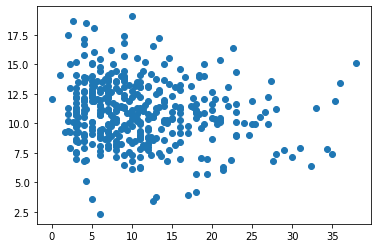

In [40]:
plt.scatter(y_test['ADAS11'],prediction)

## 6. 최종 모델 생성 및 저장

In [41]:
# 모델 만들 때에만 실행 
y=df.iloc[:,:3]
x=df.iloc[:,3:]

scaler = RobustScaler()
scaler.fit(x)

x_data = pre_data(x)

In [42]:
# basis 함수 
bas_func = [' %s + ' % ft for ft in x_data.columns]
bas_func.insert(0, 'y ~ ')
bas_func = ' '.join(''.join(bas_func).split(' ')[:-2])
bas_func

'y ~  ST102CV +  ST103CV +  ST104CV +  ST105CV +  ST106CV +  ST107CV +  ST108CV +  ST109CV +  ST110CV +  ST111CV +  ST113CV +  ST114CV +  ST115CV +  ST116CV +  ST117CV +  ST118CV +  ST119CV +  ST121CV +  ST129CV +  ST130CV +  ST13CV +  ST14CV +  ST15CV +  ST23CV +  ST24CV +  ST25CV +  ST26CV +  ST31CV +  ST32CV +  ST34CV +  ST35CV +  ST36CV +  ST38CV +  ST39CV +  ST40CV +  ST43CV +  ST44CV +  ST45CV +  ST46CV +  ST47CV +  ST48CV +  ST49CV +  ST50CV +  ST51CV +  ST52CV +  ST54CV +  ST55CV +  ST56CV +  ST57CV +  ST58CV +  ST59CV +  ST60CV +  ST62CV +  ST72CV +  ST73CV +  ST74CV +  ST82CV +  ST83CV +  ST84CV +  ST85CV +  ST90CV +  ST91CV +  ST93CV +  ST94CV +  ST95CV +  ST97CV +  ST98CV +  ST99CV +  ST102TA +  ST103TA +  ST104TA +  ST105TA +  ST106TA +  ST107TA +  ST108TA +  ST109TA +  ST110TA +  ST111TA +  ST113TA +  ST114TA +  ST115TA +  ST116TA +  ST117TA +  ST118TA +  ST119TA +  ST121TA +  ST129TA +  ST130TA +  ST13TA +  ST14TA +  ST15TA +  ST23TA +  ST24TA +  ST25TA +  ST26TA +  ST31

### a. ADAS11

In [43]:
trace = modeling(x_data, y['ADAS11'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, ST99TA, ST98TA, ST97TA, ST95TA, ST94TA, ST93TA, ST91TA, ST90TA, ST85TA, ST84TA, ST83TA, ST82TA, ST74TA, ST73TA, ST72TA, ST62TA, ST60TA, ST59TA, ST58TA, ST57TA, ST56TA, ST55TA, ST54TA, ST52TA, ST51TA, ST50TA, ST49TA, ST48TA, ST47TA, ST46TA, ST45TA, ST44TA, ST43TA, ST40TA, ST39TA, ST38TA, ST36TA, ST35TA, ST34TA, ST32TA, ST31TA, ST26TA, ST25TA, ST24TA, ST23TA, ST15TA, ST14TA, ST13TA, ST130TA, ST129TA, ST121TA, ST119TA, ST118TA, ST117TA, ST116TA, ST115TA, ST114TA, ST113TA, ST111TA, ST110TA, ST109TA, ST108TA, ST107TA, ST106TA, ST105TA, ST104TA, ST103TA, ST102TA, ST99CV, ST98CV, ST97CV, ST95CV, ST94CV, ST93CV, ST91CV, ST90CV, ST85CV, ST84CV, ST83CV, ST82CV, ST74CV, ST73CV, ST72CV, ST62CV, ST60CV, ST59CV, ST58CV, ST57CV, ST56CV, ST55CV, ST54CV, ST52CV, ST51CV, ST50CV, ST49CV, ST48CV, ST47CV, ST46CV, ST45CV, ST44CV, ST43CV, ST40CV, ST39CV, ST38CV, ST36CV, ST35CV, ST34C

In [44]:
fileObject = open("param_ADAS11.pickle",'wb')  
pickle.dump(trace, fileObject)
fileObject.close()

### b.ADAS13

In [45]:
trace = modeling(x_data, y['ADAS13'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, ST99TA, ST98TA, ST97TA, ST95TA, ST94TA, ST93TA, ST91TA, ST90TA, ST85TA, ST84TA, ST83TA, ST82TA, ST74TA, ST73TA, ST72TA, ST62TA, ST60TA, ST59TA, ST58TA, ST57TA, ST56TA, ST55TA, ST54TA, ST52TA, ST51TA, ST50TA, ST49TA, ST48TA, ST47TA, ST46TA, ST45TA, ST44TA, ST43TA, ST40TA, ST39TA, ST38TA, ST36TA, ST35TA, ST34TA, ST32TA, ST31TA, ST26TA, ST25TA, ST24TA, ST23TA, ST15TA, ST14TA, ST13TA, ST130TA, ST129TA, ST121TA, ST119TA, ST118TA, ST117TA, ST116TA, ST115TA, ST114TA, ST113TA, ST111TA, ST110TA, ST109TA, ST108TA, ST107TA, ST106TA, ST105TA, ST104TA, ST103TA, ST102TA, ST99CV, ST98CV, ST97CV, ST95CV, ST94CV, ST93CV, ST91CV, ST90CV, ST85CV, ST84CV, ST83CV, ST82CV, ST74CV, ST73CV, ST72CV, ST62CV, ST60CV, ST59CV, ST58CV, ST57CV, ST56CV, ST55CV, ST54CV, ST52CV, ST51CV, ST50CV, ST49CV, ST48CV, ST47CV, ST46CV, ST45CV, ST44CV, ST43CV, ST40CV, ST39CV, ST38CV, ST36CV, ST35CV, ST34C

In [46]:
fileObject = open("param_ADAS13.pickle",'wb')  
pickle.dump(trace, fileObject)
fileObject.close()

### c.MMSE

In [47]:
trace = modeling(x_data, y['MMSE'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, ST99TA, ST98TA, ST97TA, ST95TA, ST94TA, ST93TA, ST91TA, ST90TA, ST85TA, ST84TA, ST83TA, ST82TA, ST74TA, ST73TA, ST72TA, ST62TA, ST60TA, ST59TA, ST58TA, ST57TA, ST56TA, ST55TA, ST54TA, ST52TA, ST51TA, ST50TA, ST49TA, ST48TA, ST47TA, ST46TA, ST45TA, ST44TA, ST43TA, ST40TA, ST39TA, ST38TA, ST36TA, ST35TA, ST34TA, ST32TA, ST31TA, ST26TA, ST25TA, ST24TA, ST23TA, ST15TA, ST14TA, ST13TA, ST130TA, ST129TA, ST121TA, ST119TA, ST118TA, ST117TA, ST116TA, ST115TA, ST114TA, ST113TA, ST111TA, ST110TA, ST109TA, ST108TA, ST107TA, ST106TA, ST105TA, ST104TA, ST103TA, ST102TA, ST99CV, ST98CV, ST97CV, ST95CV, ST94CV, ST93CV, ST91CV, ST90CV, ST85CV, ST84CV, ST83CV, ST82CV, ST74CV, ST73CV, ST72CV, ST62CV, ST60CV, ST59CV, ST58CV, ST57CV, ST56CV, ST55CV, ST54CV, ST52CV, ST51CV, ST50CV, ST49CV, ST48CV, ST47CV, ST46CV, ST45CV, ST44CV, ST43CV, ST40CV, ST39CV, ST38CV, ST36CV, ST35CV, ST34C

In [48]:
fileObject = open("param_MMSE.pickle",'wb')  
pickle.dump(trace, fileObject)
fileObject.close()

## 7. Test데이터와 기존 생성한 모델 읽어와 예측 

In [49]:
trace_from_file= pickle.load(open("param_ADAS11.pickle",'rb')  )
trace=trace_from_file   #Uncomment this line if we don't want to run model again

In [50]:
w = get_weights(trace)

prediction_ADAS11 = []

for i in range(len(X_test)):
    y_hat = predict(X_test, w, i)
    prediction_ADAS11.append(y_hat)

In [51]:
trace_from_file= pickle.load(open("param_ADAS13.pickle",'rb')  )
trace=trace_from_file   #Uncomment this line if we don't want to run model again

In [52]:
w = get_weights(trace)

prediction_ADAS13 = []

for i in range(len(X_test)):
    y_hat = predict(X_test, w, i)
    prediction_ADAS13.append(y_hat)

In [53]:
trace_from_file= pickle.load(open("param_MMSE.pickle",'rb')  )
trace=trace_from_file   #Uncomment this line if we don't want to run model again

In [54]:
w = get_weights(trace)

prediction_MMSE = []

for i in range(len(X_test)):
    y_hat = predict(X_test, w, i)
    prediction_MMSE.append(y_hat)

In [ ]:
# 테스트 데이터의 독립변수들의 데이터를 X_test에 넣고
# 0~2열의 종속변수들을 각각 
# prediction_ADAS11, prediction_ADAS13, prediction_MMSE와 비교

### 과제를 마치며
> Bayesian 추론 모델은 weights, noise 등에 확률 개념을 적용시키고 베이즈 룰을 이용하여 예측하는 모델이다. 사전 확률에 데이터를 관측함으로써 알게된 likelihood를 곱해 사후확률을 점점 개선해나가면서 정답을 찾게 된다.

> 베이지안 방법의 특징으로는 이 방법을 사용하면 가중치 w는 물론이고 가중치의 불확실성 a, 노이즈 불확실성 b, 모델의 차원 M 까지 validation dataset 없이 최적의 값을 구할 수 있어서 성능에 이점이 있다고 한다. 또 다른 특징으로는 사전 확률에 결과 성능이 영향을 미치기는 하지만 많은 데이터로 학습을 거듭할 수록 ground_truth 를 찾아간다고 한다.


> 본 과제에서는 베이지안 추론을 할 때 많이 사용하는 pymc3 라이브러리를 이용해 인지 검사결과 예측을 해보았다.(실제로 베이지안 추론 방법을 활용할 일이 있으면 라이브러리를 활용할 것 같아서 이 방법이 나에게 더 도움이 될것 같았다.) 

> 결론적으로 기본적인 리니어 모델보다 좋지 않은 성능을 보였다. 스케일링, 사전확률 변경, 수동 feature selection 등을 통해 성능을 개선을 시도해 보았으나 잘 되지 않았다. 그 원인은 모델 및 라이브러리에 대한 이해가 부족해 베이지안 추론 방법의 이점을 못살렸거나, 잘못 사용한것 같다. 학습을 한번 진행하는 데에 수십분 이상 시간이 소요되어 추가적인 개선 실험을 많이 해보지 못해 아쉽다.